In [1]:
cd /nbi/group-data/JIC/Diane-Saunders/FP_project/FP_pipeline/data/0.3/Callset/2014

/nbi/Research-Groups/JIC/Diane-Saunders/FP_project/FP_pipeline/data/0.3/Callset/2014


In [2]:
import vcfnp
import numpy as np
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt

import allel
import seaborn as sns
import pandas as pd

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score,calinski_harabaz_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale

%matplotlib inline
sns.set_style('whitegrid')
mpl.rcParams['figure.figsize'] = (10, 6)


In [3]:
def compute_bic_adegenet(km,X):
    #number of clusters
    k = km.n_clusters
    #size of data set
    N, d = X.shape

    WSS = sum([np.sum((km.cluster_centers_[i] - X[km.predict(X)==i,:])**2 )
                    for i in range(km.n_clusters)])

    return(N*np.log(WSS/N) + k*np.log(N))

def plot_ld(gn, title):
    m = allel.stats.rogers_huff_r(gn) ** 2
    ax = allel.plot.pairwise_ld(m)
    ax.set_title(title)
    return m

# Loading 2014 Biallelic SNPs

In [195]:
callset = h5py.File('2014_SNPs_syn.hd5', mode='r')
genotypes = allel.GenotypeChunkedArray(callset['calldata']['GT'])
variants = allel.VariantChunkedTable(callset['variants'])
samples = list(callset['samples'][:])

In [196]:
i = np.where(callset['samples'][:] == 'LIB14656')[0]
genotypes.count_missing(axis=0)[100]/len(variants)

0.78298376707034267

# Filter Sites and Individuals


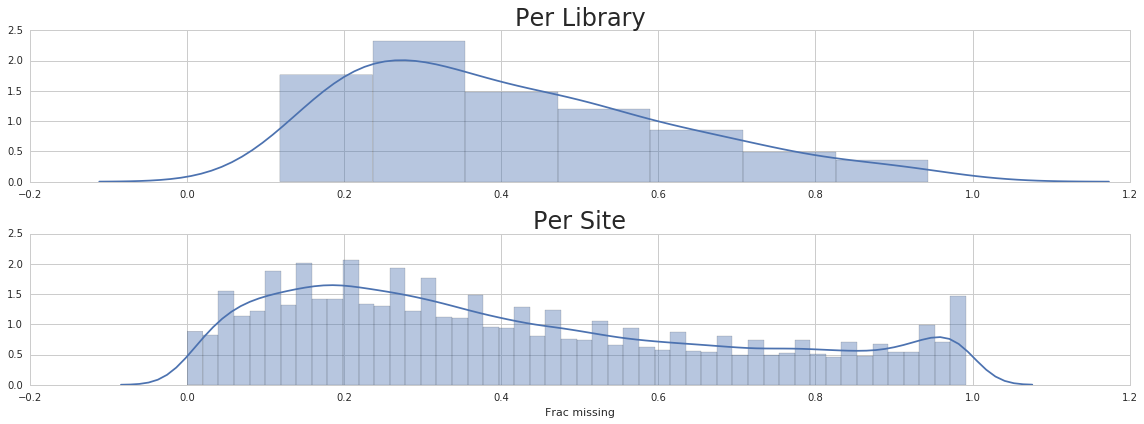

In [197]:
plt.figure(figsize=(16, 6))
sns.distplot(genotypes.count_missing(axis=0)[:]/len(variants), ax=plt.subplot(211))
sns.distplot(genotypes.count_missing(axis=1)[:]/len(samples), ax=plt.subplot(212))

plt.subplot(212).set_xlabel("Frac missing")
plt.subplot(212).set_title("Per Site", fontsize=24)
plt.subplot(211).set_title("Per Library", fontsize=24)

plt.tight_layout()

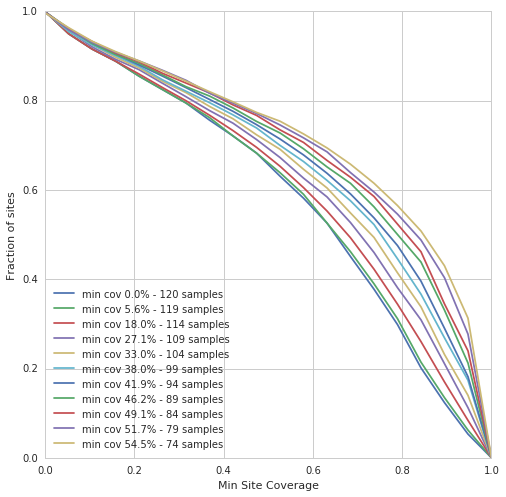

In [198]:
X = np.linspace(0., 1, 20)
plt.figure(figsize=(8,8))
sample_missing = genotypes.count_missing(axis=0)[:] / len(variants)

for s in [1] + sorted(sample_missing)[::-5][:10]:
    indvs = sample_missing < s
    if indvs.sum() == 0:
        continue
    ind_filtered = genotypes[:,indvs]
    site_missing = ind_filtered.count_missing(axis=1)[:]/ind_filtered.shape[1]
    plt.plot(1-X, [np.mean(site_missing < x) for x in X], 
             label="min cov {0:.1%} - {1} samples".format(1-s, indvs.sum()))
    
plt.legend(loc='best')
plt.xlabel("Min Site Coverage")
plt.ylabel("Fraction of sites")

## Require samples to have coverage on at least 40% of sites and each site to be covered in at least 80% of samples leaving 95,687 sites and 86 samples

In [199]:
filtered1 = genotypes[:,(genotypes.count_missing(axis=0)[:]/len(variants)) < 0.6]
samples = list(np.array(samples)[(genotypes.count_missing(axis=0)[:]/len(variants)) < 0.6])
filtered = filtered1[(filtered1.count_missing(axis=1)[:]/filtered1.shape[1]) < 0.2,:]
print(filtered.shape)
filtered

(43616, 97, 2)


<GenotypeArray shape=(43616, 97, 2) dtype=int8>
0/0 0/0 0/0 0/0 0/0 ... ./. 0/0 0/0 0/0 0/0
0/1 0/1 0/1 0/1 0/1 ... ./. 0/1 0/1 0/1 0/1
0/0 0/0 0/1 0/1 0/1 ... 0/1 0/0 0/1 0/1 0/1
...
0/0 0/0 0/1 0/1 0/1 ... 0/1 0/0 ./. 0/1 0/0
0/0 0/0 0/1 0/1 0/1 ... 0/1 0/0 0/1 0/1 ./.
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 ./. 0/1

In [200]:
n_alt = allel.AlleleCountsChunkedArray(filtered.to_n_alt(fill=-1))
n_alt = np.where(n_alt == -1, np.array([float('nan')]),n_alt)
n_alt = np.where(np.isnan(n_alt), 
                 np.nanmean(n_alt, axis=1).reshape(-1,1), 
                 n_alt)

# Linkage Disequllibrium

In [201]:
#r = allel.rogers_huff_r(n_alt)

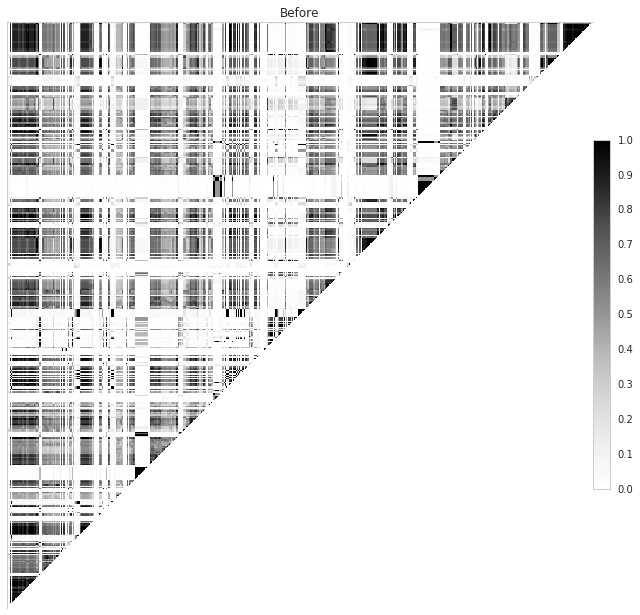

In [202]:
m = plot_ld(n_alt[:500], 'Before')

In [203]:
unlinked = n_alt[allel.locate_unlinked(n_alt),:]
print("Unlinking reduced the number of sites from {0} to {1}".format(filtered.shape[0], unlinked.shape[0]))

Unlinking reduced the number of sites from 43616 to 4932


array([ nan,  nan,  nan, ...,  nan,  nan,  nan], dtype=float32)

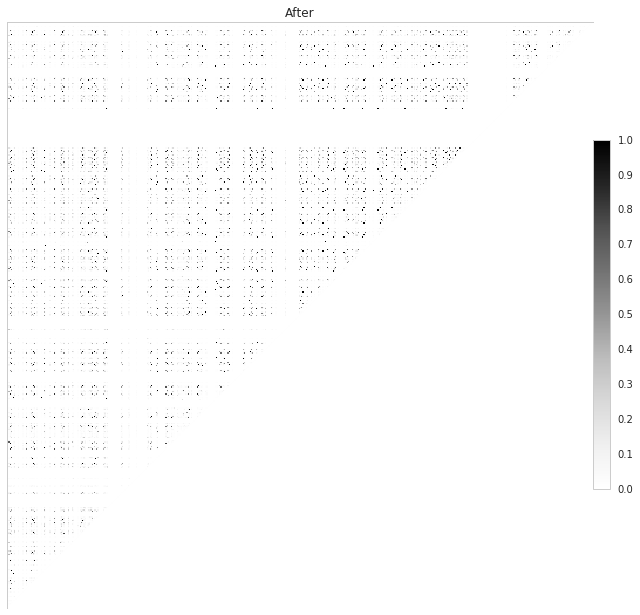

In [204]:
plot_ld(unlinked[:500], 'After')

# DAPC 

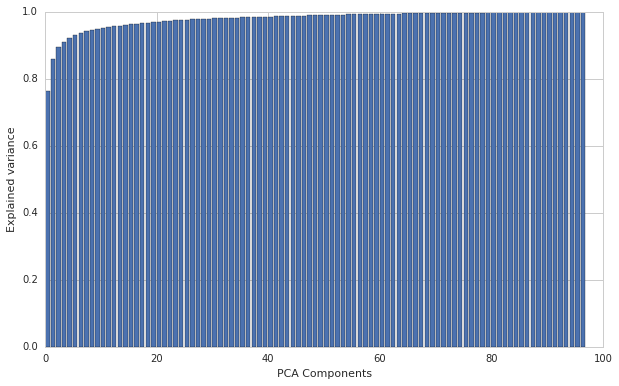

In [205]:
n_pca1 = n_alt.shape[1]
cluster_range = range(2, 25)
n_pca2 = 20
n_cluster = 4 

# Scale
X = scale(n_alt.T, with_std=False, with_mean=False)

#Permform PCA retaining all comps
pca = PCA(n_pca1)
Y = pca.fit_transform(X)
plt.bar(np.arange(n_pca1), np.cumsum(pca.explained_variance_ratio_))

plt.xlabel("PCA Components")
plt.ylabel("Explained variance")

In [206]:
# K-means clustering of the PCs
km_list = [KMeans(int(i), tol=1e-7, max_iter=1e5, n_init=100).fit(Y) for i in cluster_range]

# K selection metrics

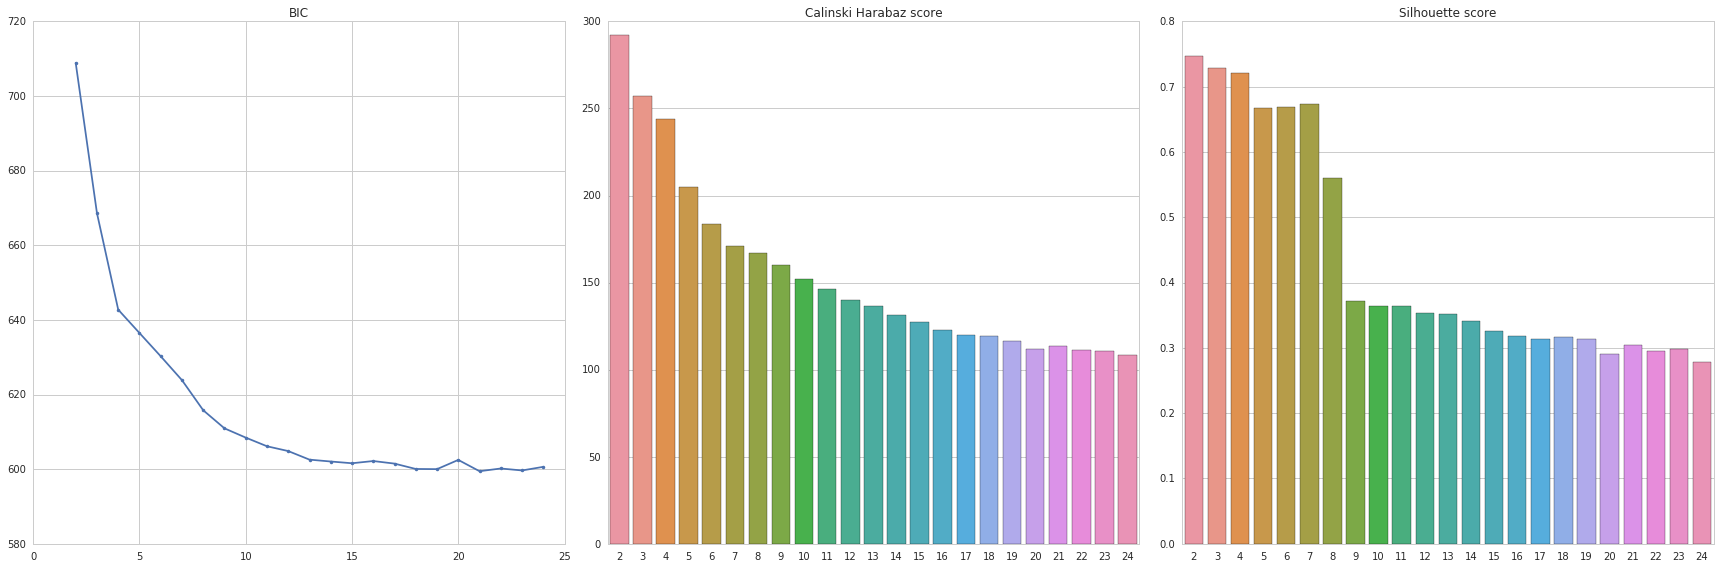

In [207]:
# Calinski Harabaz score
ch = [calinski_harabaz_score(Y,km.predict(Y)) for km in km_list]

# Silhouette Score
sil = [silhouette_score(Y,km.predict(Y)) for km in km_list]

# BIC
bic = [compute_bic_adegenet(km,Y) for km in km_list]

plt.figure(figsize=(24, 8))
plt.subplot(131).plot(list(cluster_range), bic, '.-')
plt.subplot(131).set_title("BIC")

sns.barplot(list(cluster_range), ch, ax=plt.subplot(132))
plt.subplot(132).set_title("Calinski Harabaz score")
sns.barplot(list(cluster_range), sil, ax=plt.subplot(133))
plt.subplot(133).set_title("Silhouette score")

plt.tight_layout()

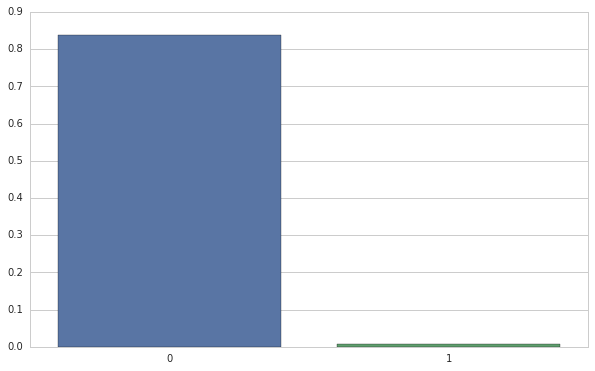

In [208]:
lda = LinearDiscriminantAnalysis(solver='eigen', tol=1e-17,  shrinkage='auto')

Z = PCA(n_pca2).fit_transform(X)
lda.fit(Z, km_list[1].predict(Y))

sns.barplot(list(range(len(lda.explained_variance_ratio_))), lda.explained_variance_ratio_**2)

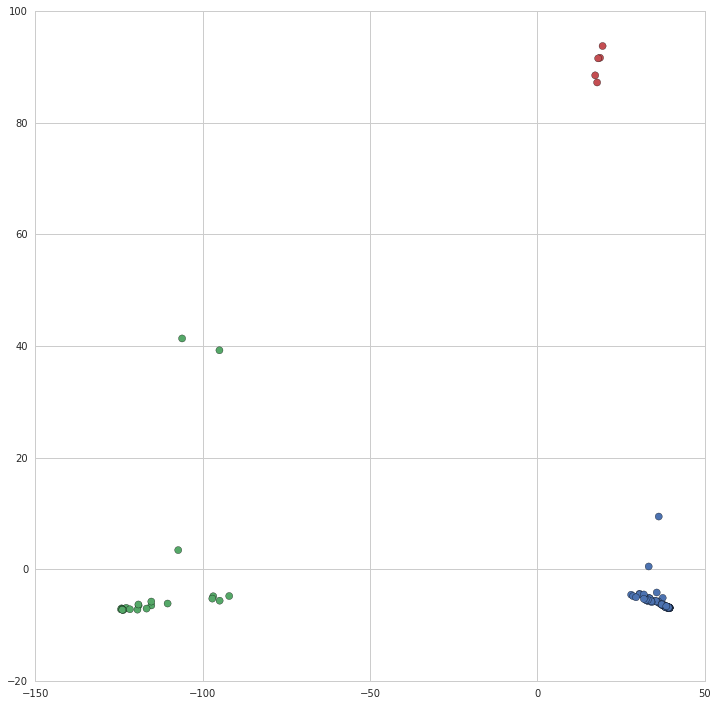

In [209]:
plt.figure(figsize=(12,12))
plt.scatter(x=lda.transform(Z)[:,0], y=lda.transform(Z)[:,1], c=[sns.color_palette(n_colors=6)[int(i)] for i in lda.predict(Z)],s=50,  marker='o')

/usr/users/ga004/buntingd/FP_dev/dev/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:523: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


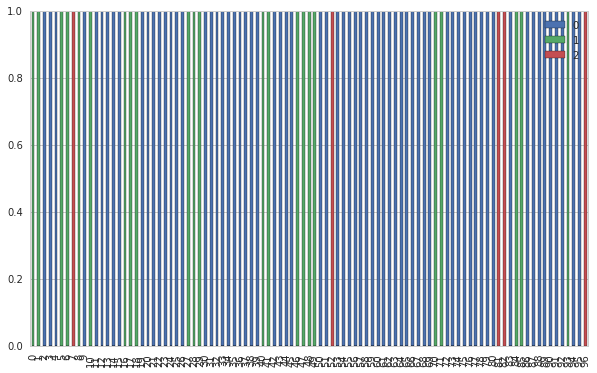

In [210]:
df = pd.DataFrame(lda.predict_proba(Z))
plt.gcf().set_size_inches(12, 4)
df.plot(kind='bar',stacked=True)

In [211]:
groups = pd.DataFrame(np.stack([list(samples), lda.predict_proba(Z).argmax(axis=1)]).T, columns=['samples', 'group'])

/usr/users/ga004/buntingd/FP_dev/dev/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:523: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


In [212]:
%load_ext rpy2.ipython
%R require(ggplot2)
%R require(ggtree)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array([1], dtype=int32)

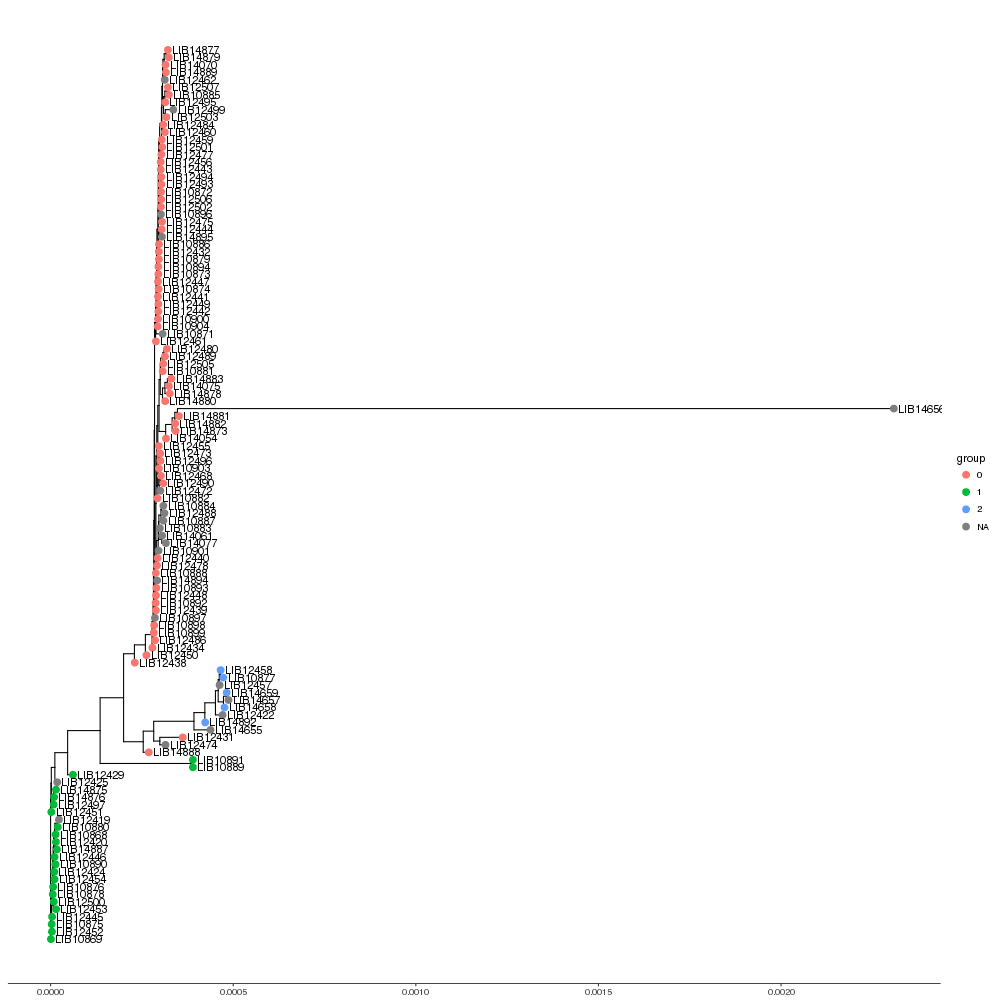

In [213]:
%%R -w1000 -h1000 -o svg -i groups

raxml1 <- read.raxml("/nbi/group-data/JIC/Diane-Saunders/FP_project/FP_pipeline/data/0.3/Tree/2014/comb/RAxML_bipartitionsBranchLabels.2014")
p <- ggtree(raxml1, layout="rectangular") 
p <- p %<+% groups 
p <- p + geom_tippoint(aes(color=group), size=3) 
p <- p + scale_colour_hue()
p <- p + theme_tree2(legend.position='right')
p <- p + geom_tiplab(size=4) 
p

In [216]:
list(callset['calldata'].keys())

['AD', 'DP', 'GQ', 'GT', 'MIN_DP', 'PGT', 'PID', 'PL', 'RGQ', 'SB']